# Libraries

In [284]:
#  Import libraries
import os
import shutil
import glob

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
import PIL
import torch
import torchvision
import torchinfo


# Data Preprocessing: Sorting images for easy training

In [285]:
# Sort images into folder

image_names = ["bicycle","bike",'bus','car','cng','easybike','leguna','truck','mixed']
train_dir = os.path.join('/kaggle/input/image-files', 'train')
images = os.listdir(train_dir)

def find_images(pattern):
    
    pattern = os.path.join(train_dir, f"*{pattern}*")
    return glob.glob(pattern)

def sort_image(image_names):
    for image in image_names:
        category = os.path.join('/kaggle/working/', image)
        os.makedirs(category, exist_ok=True)
        all_image = find_images(image)
        for file in all_image:
            destination_path = os.path.join('/kaggle/working/', image)
            shutil.copy2(file,  destination_path)
    
sort_image(image_names)

# Re organize the required images into seperate directories

In [287]:
data_dir = "/kaggle/working/"
target_classes = ["bus", "cng"]

print("Available directories:", os.listdir(data_dir))

# Ensure only valid classes are loaded
filtered = [d for d in os.listdir(data_dir) if d in target_classes]
print("Filtered classes:", filtered)

# List valid image files from the specified folders
valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp")

image_paths = []
labels = []

for cls in target_classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.exists(class_path):  # Ensure folder exists
        for file in os.listdir(class_path):
            if file.endswith(valid_extensions):
                image_paths.append(os.path.join(class_path, file))
                labels.append(cls)  # Store class label

print(f"Loaded {len(image_paths)} images from {target_classes}.")



# Define a temporary directory inside /kaggle/working/
filtered_data_dir = "/kaggle/working/filtered"
os.makedirs(filtered_data_dir, exist_ok=True)

# Copy only selected class folders
for cls in target_classes:
    src = os.path.join(data_dir, cls)
    dst = os.path.join(filtered_data_dir, cls)
    if os.path.exists(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)  # Copy files without moving them

print("Filtered dataset created at:", filtered_data_dir)




class ConvertRGB:
    def __call__(self, image):
        if image.mode != 'RBG':
            image = image.convert('RGB')
        return image

transform = torchvision.transforms.Compose(
    [ConvertRGB(),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor()]
    
)





Available directories: ['binaray', 'filtered', 'mixed', 'truck', 'model.pth', 'bicycle', 'model_checkpoint.pth', 'easybike', 'leguna', 'bike', 'bus', '.virtual_documents', 'cng', 'car']
Filtered classes: ['bus', 'cng']
Loaded 769 images from ['bus', 'cng'].
Filtered dataset created at: /kaggle/working/filtered


RGB (416, 416)


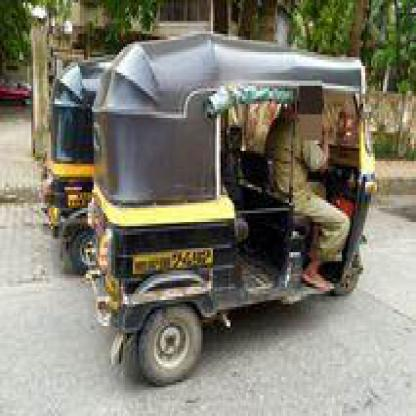

In [288]:
cng_path = '/kaggle/working/filtered/cng'
cng_images = os.listdir(cng_path)

first_cng_image = os.path.join(cng_path, cng_images[0])
print(PIL.Image.open(first_cng_image).mode, PIL.Image.open(first_cng_image).size)
PIL.Image.open(first_cng_image)
      

RGB (416, 416)


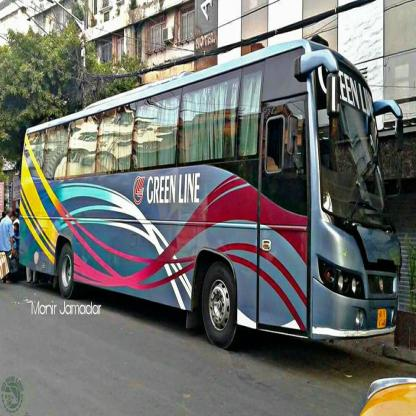

In [289]:
bus_path ='/kaggle/working/filtered/bus'
bus_images = os.listdir(bus_path)
first_bus_image = os.path.join(bus_path, bus_images[0])
print(PIL.Image.open(first_bus_image).mode, PIL.Image.open(first_bus_image).size)
PIL.Image.open(first_bus_image)

# Load the required datasets

In [290]:
dataset = torchvision.datasets.ImageFolder(root=filtered_data_dir, transform=transform)
print("Loaded dataset with classes:", dataset.classes)

Loaded dataset with classes: ['bus', 'cng']


# Split into train and validation set

In [291]:
# Split into train and test
g= torch.Generator()
g.manual_seed(42)

train_set, test_set = torch.utils.data.random_split(dataset, [0.8,0.2], generator=g)
print(f"len of train {train_set}\n len of test {test_set}")

len of train <torch.utils.data.dataset.Subset object at 0x7be617f03b90>
 len of test <torch.utils.data.dataset.Subset object at 0x7be617f36a10>


In [292]:
train_set.dataset.class_to_idx

{'bus': 0, 'cng': 1}

In [293]:
Counter(x[1] for x in dataset)

Counter({0: 360, 1: 409})

# Explore dataset for class imbalace

In [294]:
from tqdm.notebook import tqdm

def class_counter(dataset):
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.dataset.class_to_idx
    return pd.Series({name:c[x] for name, x in class_to_index.items()})

### Count class for train sets

  0%|          | 0/616 [00:00<?, ?it/s]

bus    289
cng    327
dtype: int64


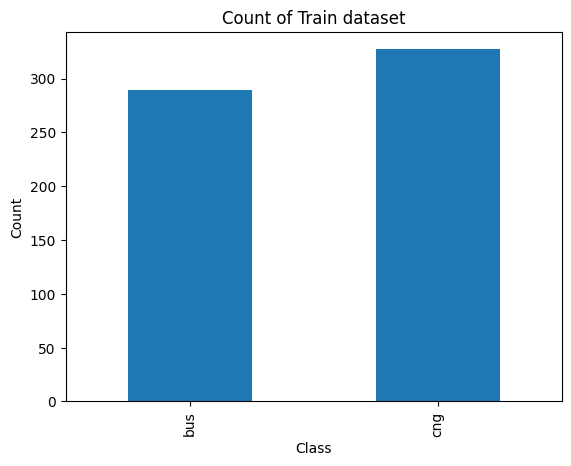

In [295]:
train_class_count = class_counter(train_set)
print(train_class_count)
train_class_count.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Count of Train dataset")
plt.show()

### Count class for test sets

  0%|          | 0/153 [00:00<?, ?it/s]

bus    71
cng    82
dtype: int64


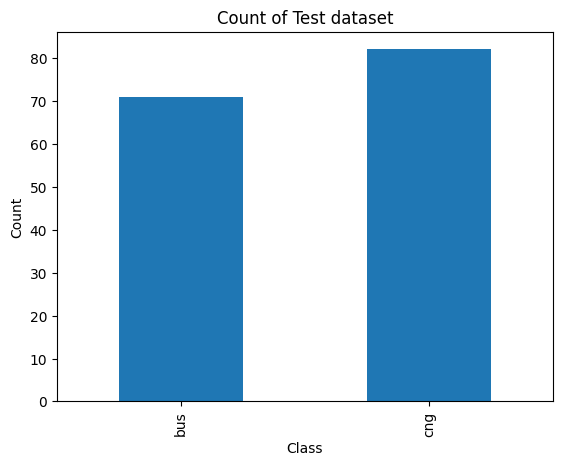

In [296]:
test_class_count = class_counter(test_set)
print(test_class_count)
test_class_count.plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Count of Test dataset")
plt.show()

# Build neural network that trains in 32 batches

In [297]:
train_data_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, generator=g)
test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, generator=g)

flatten = torch.nn.Flatten()
height = 224
weidth = 224

model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * height * weidth, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2)
    
    
)
model.to("cuda")
print(torchinfo.summary(model))

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            77,070,848
├─ReLU: 1-3                              --
├─Linear: 1-4                            65,664
├─ReLU: 1-5                              --
├─Linear: 1-6                            258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0


In [298]:
torch.cuda.is_available()

True

# Instantiate loss function and gradient descent

In [332]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train epoch function

In [333]:
def train_epoch(model, loss_fn, optimizer, dataloader, device="cuda"):
    training_loss = 0.0
    model.train()

    for input_data, target in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        model.to(device)
        input_data = input_data.to(device)
        target = target.to(device)
        #loss_fn.to(device)

        output = model(input_data)
        
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * input_data.size(0)

    return training_loss/len(dataloader.dataset)

In [334]:
loss_value = train_epoch(model, loss, optimizer, train_data_loader)
print(f"The average loss during the training epoch was {loss_value:.2f}.")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

The average loss during the training epoch was 0.39.


# Predict function

In [335]:
def predict(model, loader, device="cuda"):
    all_probs = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for input_data, target in tqdm(loader, desc="Predict", leave=False):
            input_data = input_data.to(device)
            output = model(input_data)
            probs = torch.nn.functional.softmax(output, dim=1)
            all_probs =  torch.cat([all_probs, probs], dim=0)
    return all_probs
        

In [336]:
probabilities_train = predict(model, train_data_loader, device="cuda")
probabilities_test = predict(model, test_data_loader, device="cuda")
print(probabilities_train.shape)
print(probabilities_test.shape)

Predict:   0%|          | 0/20 [00:00<?, ?it/s]

Predict:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([616, 2])
torch.Size([153, 2])


In [337]:
prediction_train = torch.argmax(probabilities_train, dim=1)
print(prediction_train.shape)
print(prediction_train[:10])

torch.Size([616])
tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')


In [338]:
target_train = torch.cat([label for _ , label in train_data_loader]).to("cuda")
is_correct_train = torch.eq(target_train, prediction_train).sum()
total_correct_train = is_correct_train
accuracy_score = total_correct_train / len(dataset)
print(f'training accuracy: {accuracy_score}')

training accuracy: 0.38621586561203003


In [339]:
prediction_test = torch.argmax(probabilities_test, dim=1)
target_test = torch.cat([label for _, label in test_data_loader]).to('cuda')
is_correct_test = torch.eq(target_test, prediction_test).sum()
accuracy_score = is_correct_test / len(dataset)
print(f'test accuracy score is {accuracy_score}')

test accuracy score is 0.08972691744565964


# Score function to evaluate model

In [340]:
def score(model, loss_fn, dataloader, device='cuda'):
    accuracy = 0
    total_loss = 0
    total_correct = 0
    model.eval()
    with torch.no_grad():
        for inputs, label in tqdm(dataloader, desc="scoring", leave=False):
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            loss= loss_fn(outputs, label)
            total_loss += loss.item() * inputs.size(0)
            
            total_correct += torch.eq(torch.argmax(outputs, dim=1), label).sum().item()
        accuracy = total_correct / len(dataloader.dataset)
        total_loss = total_loss / len(dataloader.dataset)
        return (accuracy, total_loss)

In [341]:
accuracy_train, loss_train = score(model, loss, train_data_loader)
accuracy_test, loss_test = score(model, loss, test_data_loader)
print(f"train accuracy: {accuracy_train}\ttrain loss: {loss_train}")
print(f"test accuracy: {accuracy_test}\ttest loss: {loss_test}")

scoring:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/5 [00:00<?, ?it/s]

train accuracy: 0.8425324675324676	train loss: 0.33286103877154266
test accuracy: 0.7516339869281046	test loss: 0.5381862244574852


# Epoch Train function 

In [310]:
def train(model, loss_fn, optimizer, train_loader, test_loader, device='cuda', epochs=20):
    model.train()
    total_loss = 0.0
    for epoch in range(1, epochs + 1):
        training_loss = train_epoch(model, loss_fn, optimizer, train_loader, device)
        train_accuracy, test_loss = score(model, loss_fn, train_loader, device)
        test_accuracy, test_loss = score(model, loss_fn, test_loader, device)
        print(
        f"Epoch: {epoch}, Training loss: {training_loss:.2f} Train Accuracy: {train_accuracy:.2f} "
        f"Validation Loss: {test_loss:.2f}, Validation Accuracy: {test_accuracy:.2f}")
        

In [347]:
train(model, loss, optimizer, train_data_loader, test_data_loader,device='cuda', epochs=20)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Training loss: 0.22 Train Accuracy: 0.86 Validation Loss: 0.58, Validation Accuracy: 0.73


Training:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 2, Training loss: 0.20 Train Accuracy: 0.96 Validation Loss: 0.49, Validation Accuracy: 0.79


Training:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/20 [00:00<?, ?it/s]

scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 3, Training loss: 0.20 Train Accuracy: 0.85 Validation Loss: 0.67, Validation Accuracy: 0.73


Training:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Model Evaluation: Classification Report

In [348]:
y_true = []  # Store actual labels
y_pred = []  # Store predicted labels

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)

        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())  # Convert labels to NumPy
        y_pred.extend(predictions.cpu().numpy())  # Convert predictions to NumPy

report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print(report)

              precision    recall  f1-score   support

     Class 0       0.72      0.82      0.76        71
     Class 1       0.82      0.72      0.77        82

    accuracy                           0.76       153
   macro avg       0.77      0.77      0.76       153
weighted avg       0.77      0.76      0.76       153



# Not too good model. This is my first try anyways 

In [349]:

model_path = "/kaggle/working/model1.pth"

torch.save(model.state_dict(), model_path)

print(f"Model saved successfully at {model_path}")


Model saved successfully at /kaggle/working/model1.pth


In [351]:
from IPython.display import FileLink

model_path = "/kaggle/working/model1.pth"
FileLink(model_path)


/kaggle/working/model1.pth

In [354]:
import shutil

shutil.make_archive("/kaggle/working/model_backup", "zip", "/kaggle/working/model1.pth")


NotADirectoryError: [Errno 20] Not a directory: '/kaggle/working/model1.pth'